## LIBRARIES

In [185]:
# !pip install pmdarima

In [186]:
import pandas as pd
import numpy as np
import os

# Viz ------------------------------------------------------------
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Date -----------------------------------------------------------
from datetime import datetime
import calendar

# Model ----------------------------------------------------------
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats as ss
from scipy import signal
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Pandas profiling
# from pandas_profiling import ProfileReport

In [187]:
#from google.colab import drive
#drive.mount('DATA')

Drive already mounted at DATA; to attempt to forcibly remount, call drive.mount("DATA", force_remount=True).


## Funtions

In [188]:
def test_stationarity(timeseries):
    # rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # rolling statistics plot
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [189]:
def decompose_time_series(timeseries, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0, plot_components=True):
    decomposition = seasonal_decompose(timeseries, model=model, filt=filt, period=period, two_sided=two_sided, extrapolate_trend=extrapolate_trend)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    if plot_components:
        plt.figure(figsize=(10,10))

        plt.subplot(411)
        plt.plot(timeseries, label='Original')
        plt.legend(loc='best')
        plt.title("Original Time Series")
        plt.xlabel("Time")
        plt.ylabel("Value")

        plt.subplot(412)
        plt.plot(trend, label='Trend')
        plt.legend(loc='best')
        plt.title("Trend Component")
        plt.xlabel("Time")
        plt.ylabel("Value")

        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality')
        plt.legend(loc='best')
        plt.title("Seasonal Component")
        plt.xlabel("Time")
        plt.ylabel("Value")

        plt.subplot(414)
        plt.plot(residual, label='Residuals')
        plt.legend(loc='best')
        plt.title("Residual Component")
        plt.xlabel("Time")
        plt.ylabel("Value")

        plt.tight_layout()

    return trend, seasonal, residual

## Data set: Data Model (Allboas and Research)

In [190]:
df = pd.read_csv('H:\My Drive\QEnergy\Results\Model (S) ARIMA\OFFER_BATT_MEAN.csv')

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192757 entries, 0 to 1192756
Data columns (total 70 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   recordtype                     1192757 non-null  object 
 1   settlementDate                 1192757 non-null  object 
 2   settlementPeriod               1192757 non-null  int64  
 3   BMU ID                         1192757 non-null  object 
 4   acceptedprice                  1192757 non-null  float64
 5   acceptedvolume                 1192757 non-null  float64
 6   BMU Type                       1192757 non-null  object 
 7   BMU Fuel Type                  1192757 non-null  object 
 8   BMU GSP Group Name             1192757 non-null  object 
 9   LOC LAT                        1192757 non-null  float64
 10  LOC LONG                       1192757 non-null  float64
 11  LOC Center LAT                 1192757 non-null  float64
 12  LOC Center LON

In [192]:
df.columns

Index(['recordtype', 'settlementDate', 'settlementPeriod', 'BMU ID',
       'acceptedprice', 'acceptedvolume', 'BMU Type', 'BMU Fuel Type',
       'BMU GSP Group Name', 'LOC LAT', 'LOC LONG', 'LOC Center LAT',
       'LOC Center LONG', 'BZONE', 'BZONE GENERATION', 'BZONE DEMAND', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Z11', 'Z12',
       'Z13', 'Z14', 'Z15', 'Z16', 'Z17', 'BMU Party ID', 'Trading Unit',
       'PC Flag', 'PC Status', 'Transmission Loss Factor',
       'Generation Capacity', 'Demand Capacity', 'Exempt Export Flag',
       'Base TU Flag', 'FPN Flag', 'Weekend', 'Holiday', 'Year', 'Month',
       'Day', 'Weekday_SIN', 'Weekday_COS', 'Month_SIN', 'Month_COS',
       'Day_SIN', 'Day_COS', 'settPeriod_SIN', 'settPeriod_COS', 'DANF_Demand',
       'DAID_spnDemand', 'DAIG_spnGeneration', 'DATF_Demand',
       'SystemTotalLoad_Consumption', 'DAMargin', 'DAImbalance',
       'GenerationForecast_Production', 'Solar_Generation',
       'WindOffshore_G

## Test Times series

### Preparing DataSets for TimeSeries.

In [193]:
df['settlementDate'] = pd.to_datetime(df['settlementDate'])

In [194]:
df_grouped = df.groupby(['settlementDate','settlementPeriod']).agg(
    {'acceptedprice': 'mean',
     'acceptedvolume': ['sum', 'mean']}
)

In [195]:
df_grouped.head()

acceptedprice acceptedvolume            
                                         mean            sum        mean
settlementDate settlementPeriod                                         
2021-01-01     1                    50.690625       1829.388  114.336750
               2                    51.065625       2011.166  125.697875
               3                    44.968947       1351.468   71.129895
               4                    45.505500        756.721   37.836050
               5                    49.137143        239.818   17.129857

In [ ]:
# Reset the index so 'settlementDate' and 'settlementPeriod' become regular columns
df_grouped = df_grouped.reset_index()

# Combine 'settlementDate' and 'settlementPeriod' into a single datetime column
df_grouped['Time'] = pd.to_datetime(df_grouped['settlementDate']) + pd.to_timedelta((df_grouped['settlementPeriod']-1)*30, unit='m')

# Set 'datetime' as the new index
df_grouped.set_index('Time', inplace=True)

In [ ]:
df_grouped.columns = ['settlementDate', 'settlementPeriod', 'av_acpr', 'sum_acpr', 'av_acvol']
df_grouped

,settlementDate,settlementPeriod,av_acpr,sum_acpr,av_acvol
Time,,,,,
2021-01-01 00:00:00,2021-01-01,1,50.690625,1829.388,114.336750
2021-01-01 00:30:00,2021-01-01,2,51.065625,2011.166,125.697875
2021-01-01 01:00:00,2021-01-01,3,44.968947,1351.468,71.129895
2021-01-01 01:30:00,2021-01-01,4,45.505500,756.721,37.836050
2021-01-01 02:00:00,2021-01-01,5,49.137143,239.818,17.129857
...,...,...,...,...,...
2023-06-30 21:30:00,2023-06-30,44,84.364211,-491.058,-25.845158
2023-06-30 22:00:00,2023-06-30,45,72.238824,-167.966,-9.880353
2023-06-30 22:30:00,2023-06-30,46,80.378906,-45.288,-1.415250


In [ ]:
tsdf = df_grouped['av_acpr']
tsdf.head()

Time
2021-01-01 00:00:00    50.690625
2021-01-01 00:30:00    51.065625
2021-01-01 01:00:00    44.968947
2021-01-01 01:30:00    45.505500
2021-01-01 02:00:00    49.137143
Name: av_acpr, dtype: float64

### T.S. Assumtions

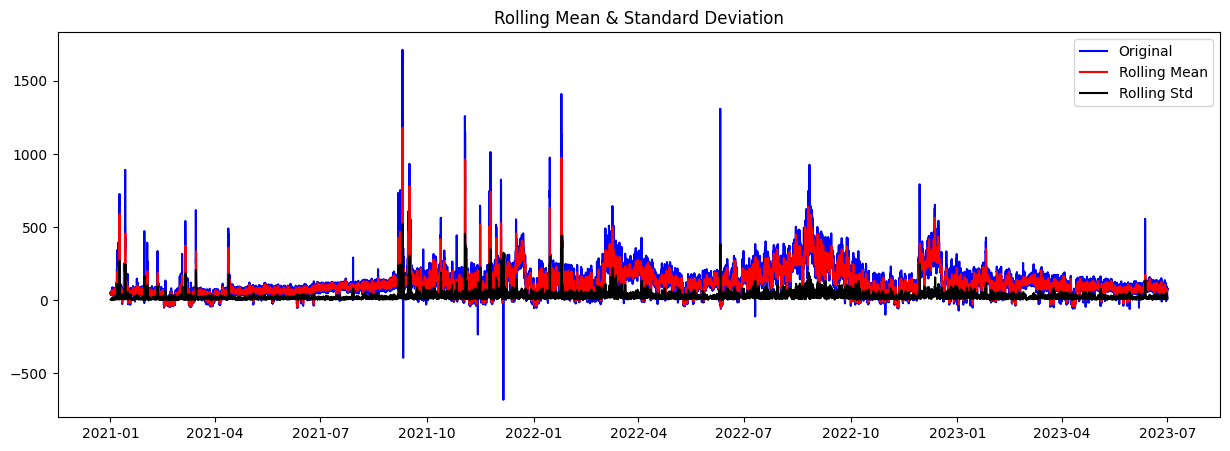

Results of Dickey Fuller Test:
Test Statistic                -1.120265e+01
p-value                        2.224050e-20
#Lags Used                     5.200000e+01
Number of Observations Used    4.327300e+04
Critical Value (1%)           -3.430501e+00
Critical Value (5%)           -2.861607e+00
Critical Value (10%)          -2.566806e+00
dtype: float64


In [ ]:
test_stationarity(tsdf)

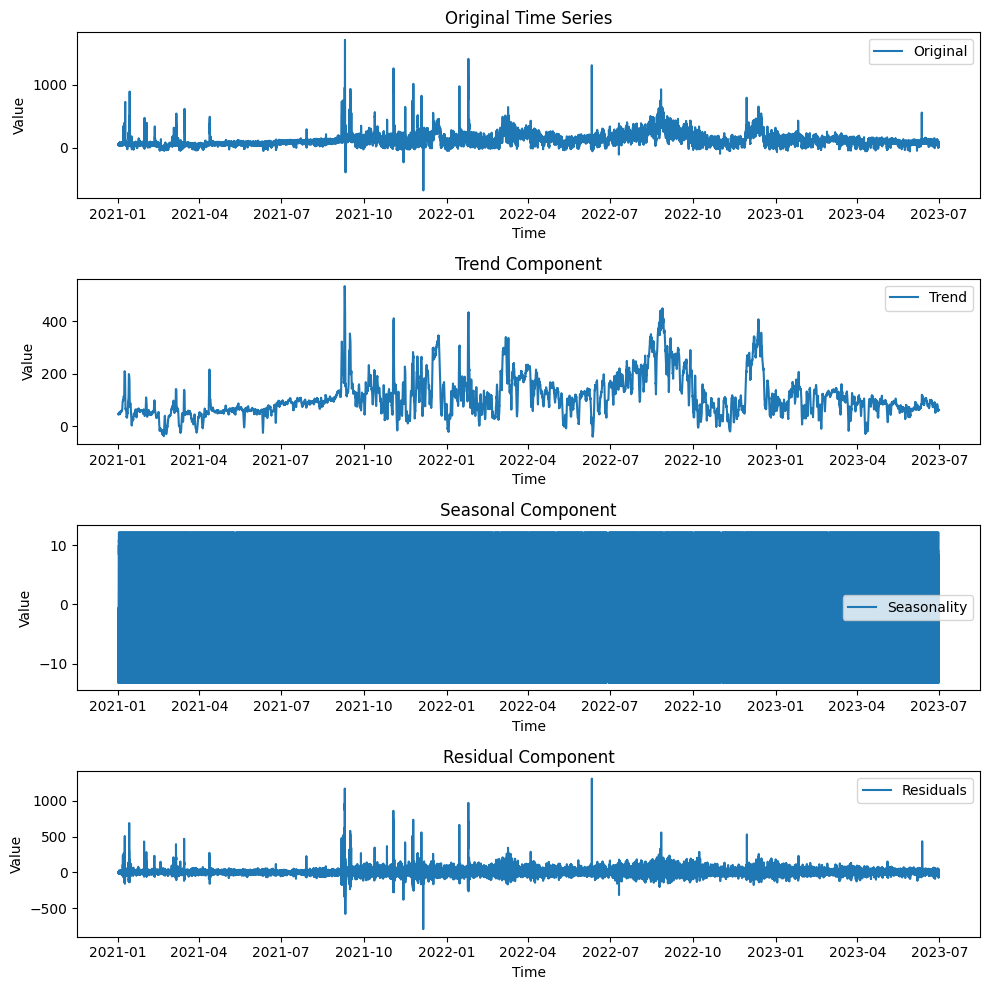

In [ ]:
trend, seasonal, residual = decompose_time_series(tsdf, period=48, plot_components=True)

#### 6 months

In [ ]:
start_date = '2022-06-01'
end_date = '2022-12-31'
subset_df = tsdf[start_date:end_date]

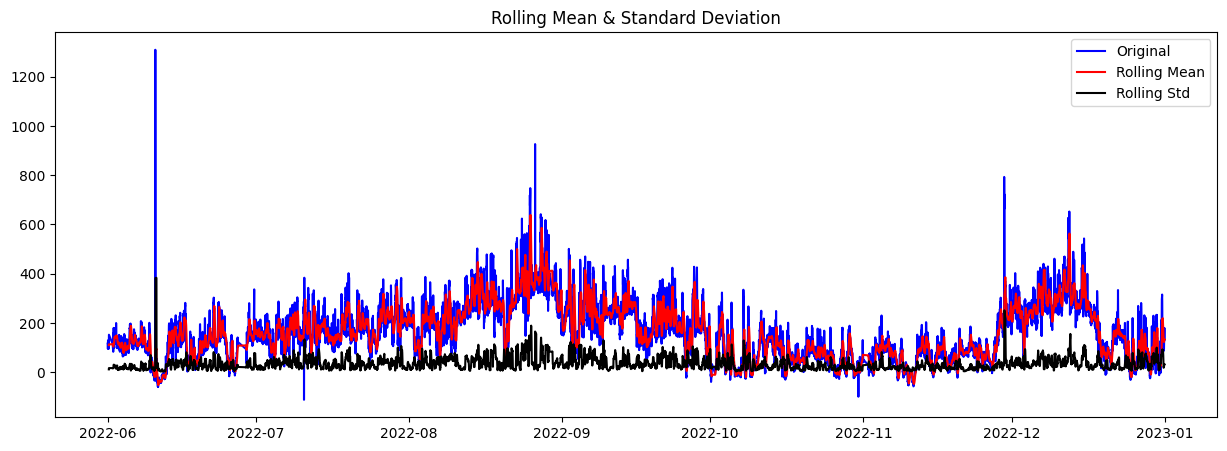

Results of Dickey Fuller Test:
Test Statistic                   -4.720031
p-value                           0.000077
#Lags Used                       38.000000
Number of Observations Used    9991.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


In [ ]:
test_stationarity(subset_df)

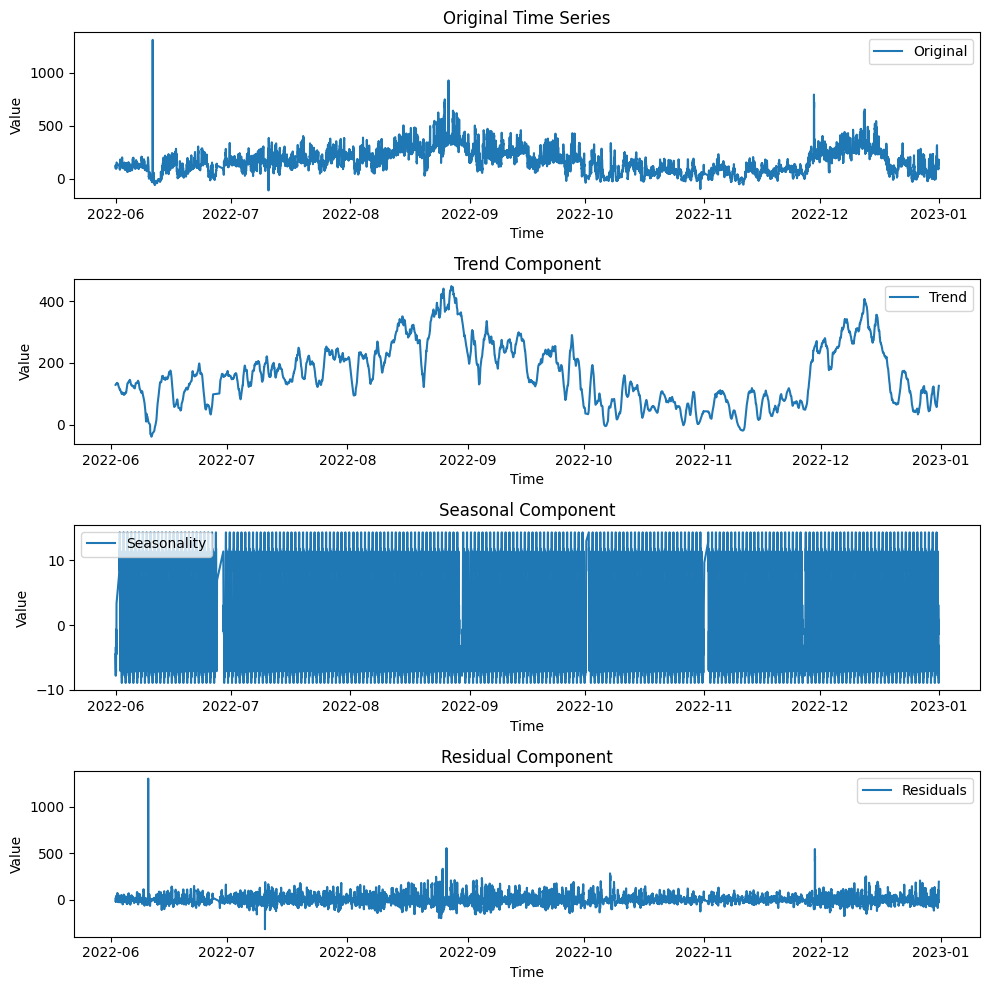

In [ ]:
trend, seasonal, residual = decompose_time_series(subset_df, period=48, plot_components=True)

#### 2 Months

In [ ]:
start_date = '2022-11-01'
end_date = '2022-12-31'
subset_df = tsdf[start_date:end_date]

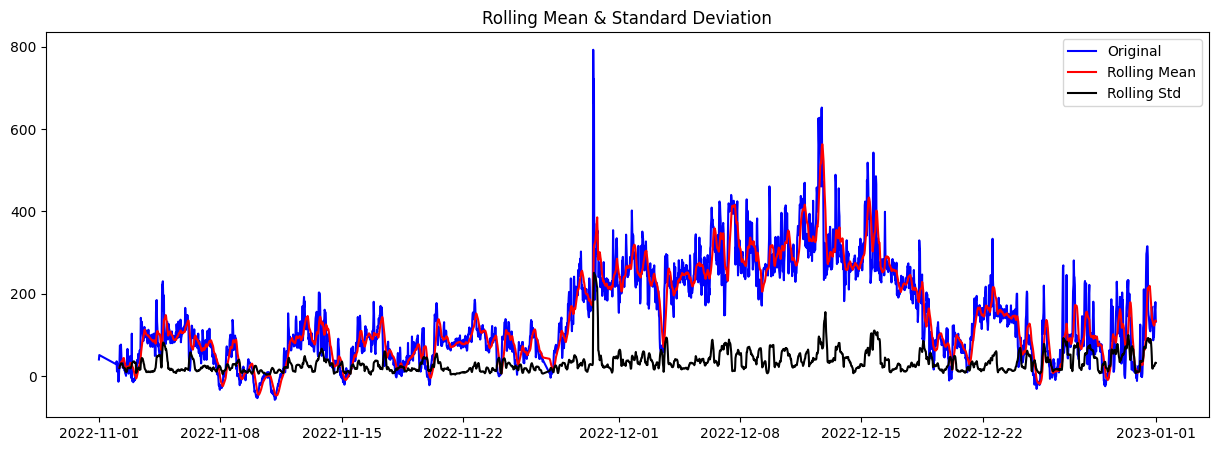

Results of Dickey Fuller Test:
Test Statistic                   -3.079693
p-value                           0.028093
#Lags Used                       21.000000
Number of Observations Used    2843.000000
Critical Value (1%)              -3.432652
Critical Value (5%)              -2.862557
Critical Value (10%)             -2.567311
dtype: float64


In [ ]:
test_stationarity(subset_df)

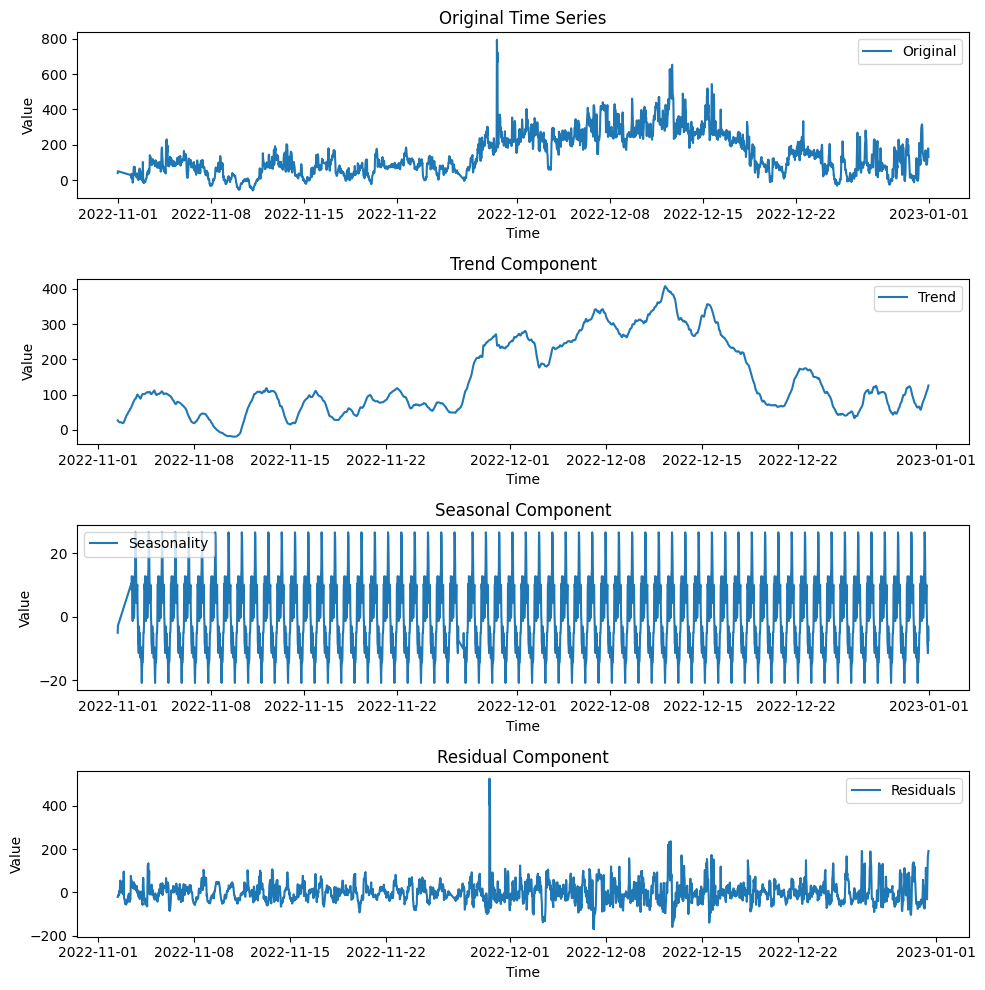

In [ ]:
trend, seasonal, residual = decompose_time_series(subset_df, period=48, plot_components=True)

#### 1 month

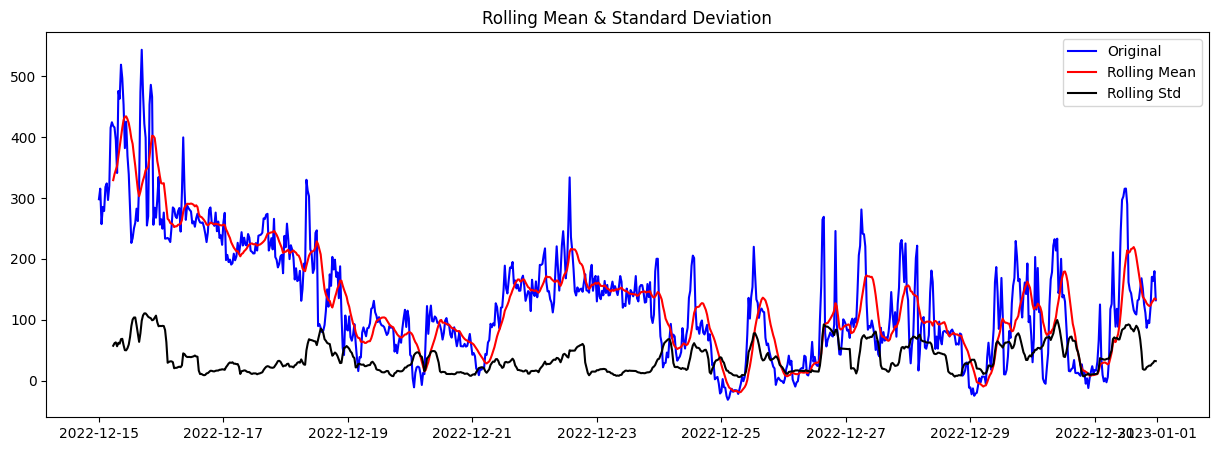

Results of Dickey Fuller Test:
Test Statistic                  -4.044164
p-value                          0.001196
#Lags Used                       4.000000
Number of Observations Used    811.000000
Critical Value (1%)             -3.438439
Critical Value (5%)             -2.865110
Critical Value (10%)            -2.568671
dtype: float64


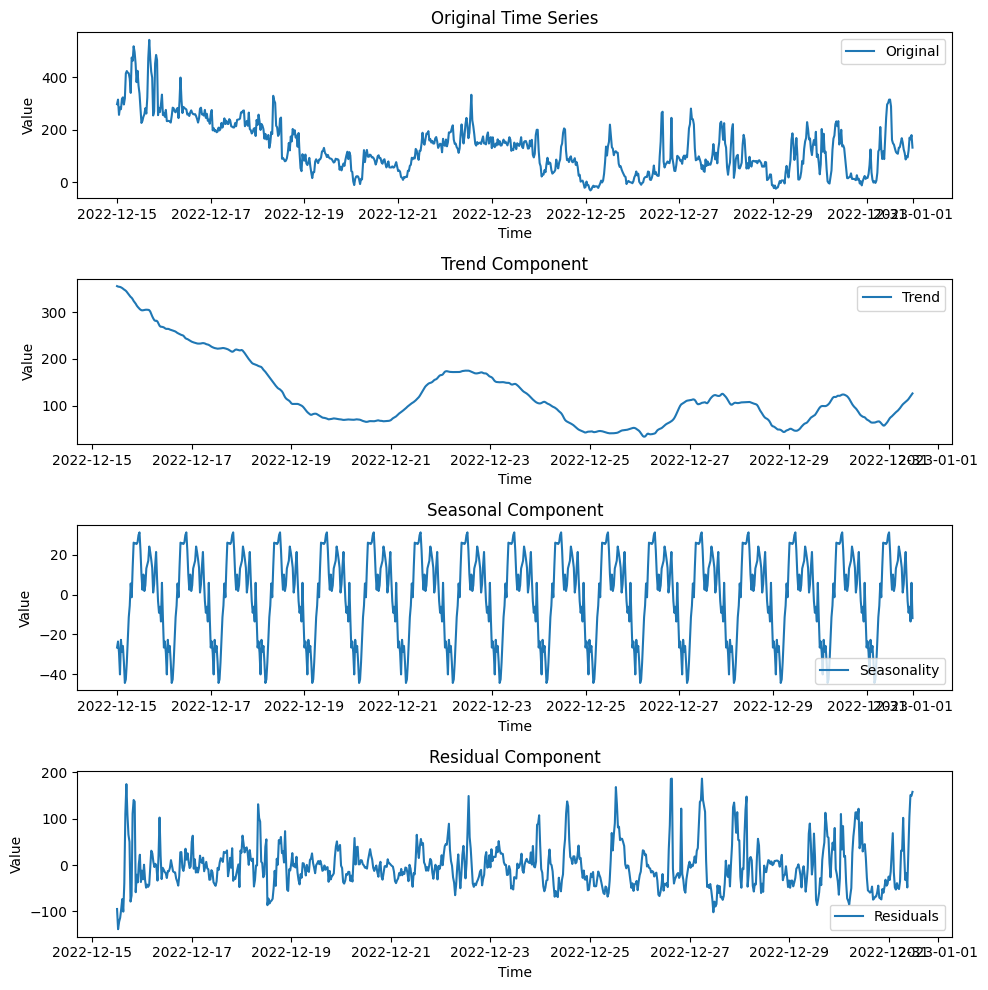

In [ ]:
start_date = '2022-12-15'
end_date = '2022-12-31'
subset_df = tsdf[start_date:end_date]
test_stationarity(subset_df)
trend, seasonal, residual = decompose_time_series(subset_df, period=48, plot_components=True)

In [ ]:
start_date = '2022-12-01'
end_date = '2022-12-31'
subset_df = tsdf[start_date:end_date]
subset_df = subset_df.diff(192).dropna()

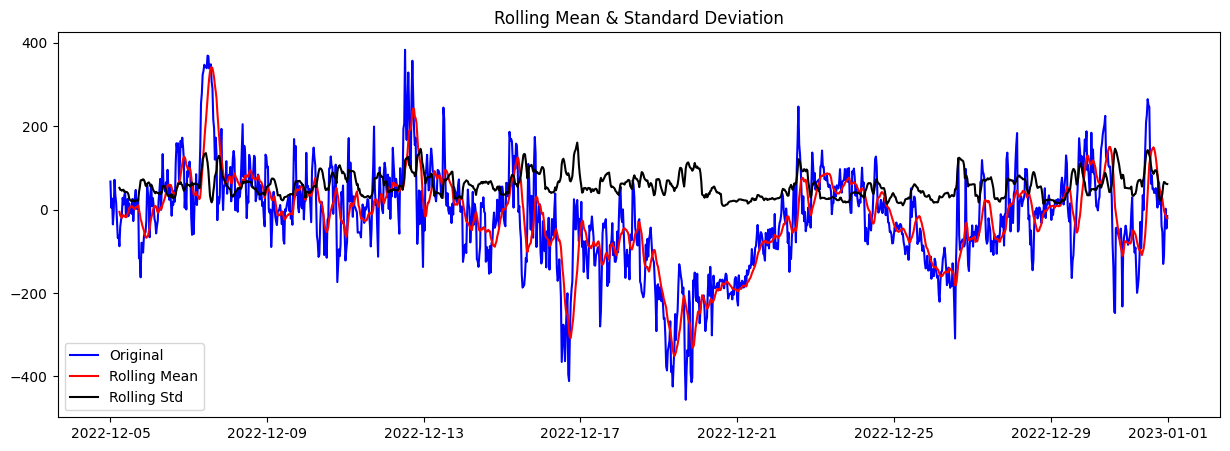

Results of Dickey Fuller Test:
Test Statistic                   -3.561883
p-value                           0.006533
#Lags Used                       16.000000
Number of Observations Used    1279.000000
Critical Value (1%)              -3.435473
Critical Value (5%)              -2.863802
Critical Value (10%)             -2.567975
dtype: float64


In [ ]:
test_stationarity(subset_df)

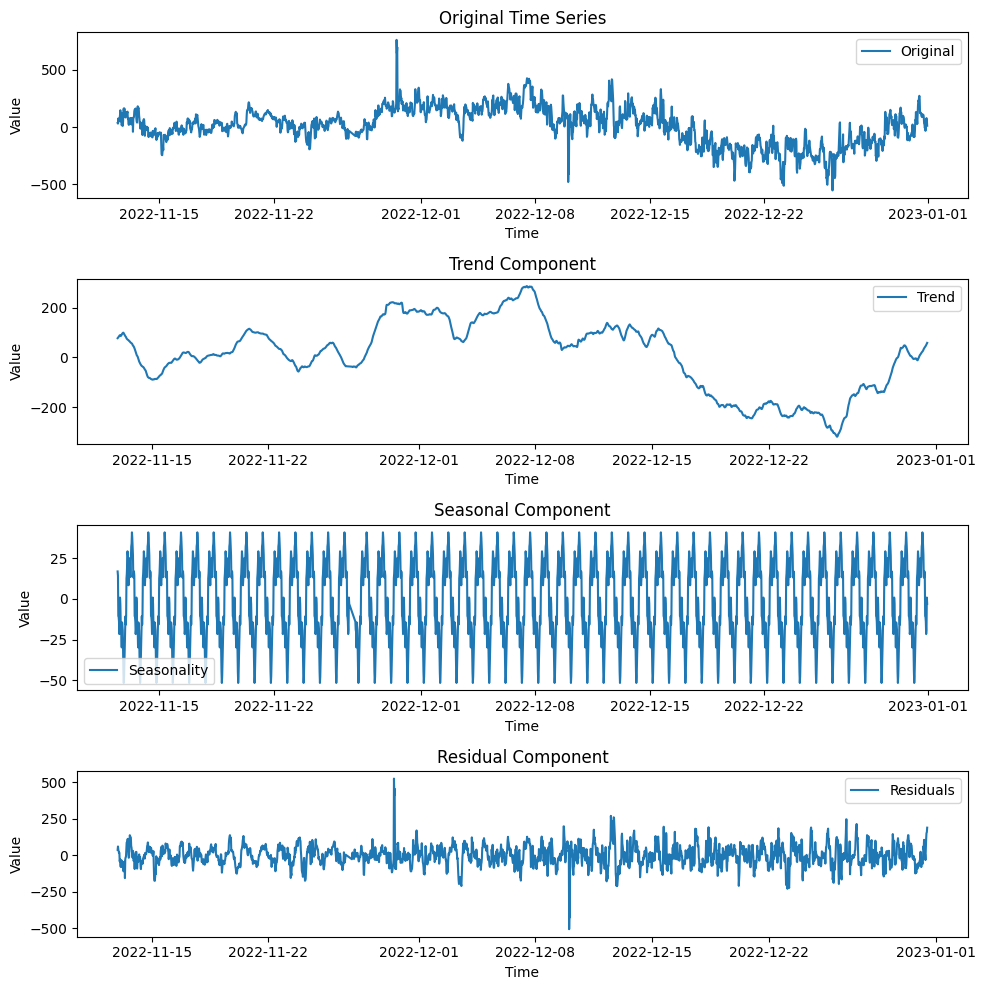

In [ ]:
trend, seasonal, residual = decompose_time_series(subset_df, period=48, plot_components=True)

## EDA

Pandas profiling

In [ ]:
df['settlementDate'].max(), df['settlementDate'].min()

('2023-06-30', '2021-01-01')

In [ ]:
#prof = ProfileReport(df)
#prof.to_file(output_file='PPModel.html')

## ARIMA

## RandomForestRegressor